## Model Creation

Let's create a model first, with some vocab.
The output is a dataset.

In [1]:
%pip install librosa numpy soundfile torch torchaudio datasets transformers 

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import WavLMModel, AutoFeatureExtractor
import datasets

# ————————————————————————————————————————————————————————————————————————
# PhonemeRecognizer: WavLM + CTC for phoneme speech recognition
# ————————————————————————————————————————————————————————————————————————

# Load vocab from file
with open("phoneme_tokenizer/vocab.json") as vocab_file:
    vocab = json.load(vocab_file)

# IT + FR phonemes + blank
VOCAB = {
  "0": "ʒ",
  "1": "ɹ",
  "2": "j",
  "3": "d",
  "4": "ɲ",
  "5": "ʌ",
  "6": "[UNK]",
  "7": "ɒ",
  "8": "ɐ",
  "9": "ʃ",
  "10": "ɔ",
  "11": "f",
  "12": "ø",
  "13": "z",
  "14": "ŋ",
  "15": "i",
  "16": "u",
  "17": "̃",
  "18": "o",
  "19": "œ",
  "20": "a",
  "21": "(",
  "22": "ə",
  "23": "ɜ",
  "24": "ɾ",
  "25": "ː",
  "26": "̪",
  "27": "e",
  "28": "b",
  "29": "ʁ",
  "30": "w",
  "31": "n",
  "32": "p",
  "33": "y",
  "34": "ɡ",
  "35": "ɪ",
  "36": "r",
  "37": "v",
  "38": "t",
  "39": ")",
  "40": "m",
  "41": "k",
  "42": "ʊ",
  "43": "ʎ",
  "44": "ɑ",
  "45": "s",
  "46": "l",
  "47": "[PAD]",
  "48": "ɛ",
  "49": '<blank>' # blank token for CTC
}
PHONEME_DICT = {v: int(k) for k, v in VOCAB.items()}

NUM_PHONEMES = len(PHONEME_DICT)

class PhonemeRecognizer(nn.Module):
    def __init__(self, wavlm_model, num_phonemes=NUM_PHONEMES):
        super().__init__()
        self.wavlm = wavlm_model

        # Get the hidden size from the WavLM model
        hidden_size = self.wavlm.config.hidden_size

        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(0.1)

        # Linear layer to map from WavLM hidden states to phoneme classes (including blank)
        self.phoneme_classifier = nn.Linear(hidden_size, num_phonemes)

    def forward(self, inputs):
        # Get WavLM embeddings
        outputs = self.wavlm(**inputs)
        hidden_states = outputs.last_hidden_state

        # Apply dropout
        hidden_states = self.dropout(hidden_states)

        # Apply the linear layer to get logits for each time step
        logits = self.phoneme_classifier(hidden_states)

        # Apply log softmax for CTC loss
        log_probs = F.log_softmax(logits, dim=-1)

        return log_probs
    
    def classify_to_phonemes(self, log_probs):
        # Simple greedy decoding (for demonstration)
        # In a real system, you would use beam search with ctcdecode
        predictions = torch.argmax(log_probs, dim=-1).cpu().numpy()

        # Convert to phoneme sequences with CTC decoding rules (merge repeats, remove blanks)
        phoneme_sequences = []
        for pred_seq in predictions:
            seq = []
            prev = -1
            for p in pred_seq:
                # Skip blanks (index 0) and repeated phonemes (CTC rules)
                if p != 0 and p != prev:
                    # Convert index back to phoneme
                    phoneme = list(PHONEME_DICT.keys())[list(PHONEME_DICT.values()).index(p)]
                    seq.append(phoneme)
                prev = p
            phoneme_sequences.append(seq)

        return phoneme_sequences


    def recognize(self, inputs, beam_width=100):
        """Perform phoneme recognition without beam search decoding"""
        self.eval()
        with torch.no_grad():
            # Forward pass to get log probabilities
            log_probs = self(inputs)

            return self.classify_to_phonemes(log_probs)

    def tokenize(self, char_list):
        """Go from a list of characters to a list of indices."""
        return torch.tensor([PHONEME_DICT[x] for x in char_list])
    
    def get_embedding(self, char_list):
        tokens = self.tokenize(char_list)
        out_tensor = torch.zeros((len(tokens), len(PHONEME_DICT)))
        for i, token_id in enumerate(tokens):
            out_tensor[i, token_id] = 1
        return out_tensor

# ————————————————————————————————————————————————————————————————————————
# Method A: Using the PhonemeRecognizer for speech-to-phoneme ASR
# ————————————————————————————————————————————————————————————————————————

# 1. Load the feature extractor and model
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-base-plus")

# Create the phoneme recognizer with the WavLM model
phoneme_recognizer = PhonemeRecognizer(wavlm_model)
phoneme_recognizer.eval()  # disable dropout, etc.

# 2. Load an example audio file (here using a small demo from `datasets`)
#    The `audio["array"]` is a NumPy array of floats; sampling_rate is an int.
ds = datasets.load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation")
audio_sample = ds[0]["audio"]["array"]
sr = ds[0]["audio"]["sampling_rate"]

def get_audio_features(data_row):
    audio_sample = data_row["audio"]["array"]
    sr = data_row["audio"]["sampling_rate"]

    # 3. Preprocess (pad/truncate + batch‐dim)
    inputs = feature_extractor(
        audio_sample,
        sampling_rate=sr,
        return_tensors="pt",        # => PyTorch tensors
        padding=True,               # pad to longest in batch
    )
    return inputs

def run_inference(data_row, model):
    """Return log probs and most likely phonemes."""
    inputs = get_audio_features(data_row)

    # 4. Inference for phoneme recognition
    with torch.no_grad():
        # Get phoneme log probabilities
        log_probs = model(inputs)

        # Recognize phoneme sequence
        phoneme_sequences = model.recognize(inputs)

    return log_probs, phoneme_sequences

log_probs, phoneme_sequences = run_inference(ds[0], phoneme_recognizer)

# Print output
print("Log probabilities shape:", log_probs.shape)  # (batch_size, seq_len, num_phonemes)
print("Recognized phoneme sequence:", phoneme_sequences[0])
print("Transcript for reference:", ds[0]["text"])

/home/h/Documents/Travail/Collaborateur FCBG/dev/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Log probabilities shape: torch.Size([1, 292, 50])
Recognized phoneme sequence: ['ɜ', 'ɐ', 'ɛ', 'ɜ', 'ɛ', '<blank>', 's', 'ɪ', 's', 'ɪ', 's', 'k', 'ɑ', 'd', 'ŋ', 'z', 'r', 's', 'ɜ', 'ɔ', 'ɪ', '<blank>', 'œ', 'ɡ', 'ɛ', ')', 'k', 'ɜ', 'ɔ', 'ŋ', 'ː', 'a', 't', 'a', '<blank>', '̪', '<blank>', 'v', 'ɑ', 'ɛ', 'ɜ', '<blank>', 'k', 'ɲ', 'a', '̃', 'ɲ', '̃', '(', ')', '[PAD]', 'p', 'ɜ', 'm', 'r', '̪', 'ɛ', '̪', 'n', 'ɜ', 'ɹ', 'ɪ', ')', 'ɪ', '<blank>', '[PAD]', 'ɾ', 'ɔ', 'ɪ', 'œ', '<blank>', 'a', '[PAD]', 'ɪ', 'ɑ', 'ɜ', 'ɛ', '<blank>', 'ɒ', 'ɜ', '[PAD]', 'ɲ', '<blank>', 'm', 't', ')', 'y', 'ɪ', 'z', 'ŋ', 'm', 'ɪ', ')', 'ɪ', '<blank>', 'ɪ', '[PAD]', 'ɡ', 'ɪ', 'ɡ', 't', 'j', 'ʌ', 'ŋ', 'ʌ', 'v', 'a', 'ɑ', 'r', 't', 'd', 'ɜ', '[UNK]', 'ʌ', 'ʊ', 'ɡ', 'y', 'ɑ', 'ɹ', '̪', 'ŋ', 'ʌ', 't', 'ɑ', ')', 'ɜ', 'j', '<blank>', ')', 'ɡ', 'ɪ', '[UNK]', 'ɒ', 'ŋ', 'y', 'ɜ', '<blank>', 'm', 'k', 'ɲ', 't', ')', 'ː', '̃', ')', '[PAD]', 'ɜ', '̪', 'ɜ', 'ɑ', 'a', 'n', 'ɪ', 'ɹ', 'ɪ', 'z', '(', 's', 'ɲ', 'ɑ', 's', 'ɪ', '̃', '

## Dataset

Let's load our data in a Hugging Face dataset.

In [ ]:
import datasets

# 1. Location of your CSV
# csv_file = "train_phonemes_clean.csv"  # replace with your path
csv_file = "ground_truth_it_coder_2.csv"  # replace with your path


# 2. Define initial features: audio paths as plain strings, phonemes as plain strings
features = datasets.Features({
    "file_name": datasets.Value("string"),
    "phoneme_sequence": datasets.Value("string"),
})

# 3. Load the CSV into a DatasetDict (default split is 'train')
ds_dict = datasets.load_dataset("csv", data_files=csv_file, features=features)
dataset = ds_dict["train"]

# 4. Rename the audio-path column to 'audio' (required by Audio feature)
dataset = dataset.rename_column("file_name", "audio")

# 5. Cast 'audio' to the Audio type (will load the file when you access it)
dataset = dataset.cast_column("audio", datasets.Audio(sampling_rate=16_000))

# 6. Map + split phoneme strings into lists
def split_phonemes(example):
    # assume phonemes are space-separated, e.g. "AH0 T EH1 S T"
    example["phoneme_sequence"] = example["phoneme_sequence"].split()
    return example

dataset = dataset.map(split_phonemes)

# 7. Cast the phoneme_sequence column to a Sequence of strings
dataset = dataset.cast_column(
    "phoneme_sequence",
    datasets.Sequence(feature=datasets.Value("string"))
)

# Now 'dataset' has:
#   - dataset[i]["audio"] → { "array": np.ndarray, "sampling_rate": 16000 }
#   - dataset[i]["phoneme_sequence"] → list of strings
print(dataset)
print(dataset[0]["audio"])
print(dataset[0]["phoneme_sequence"])


Dataset({
    features: ['audio', 'phoneme_sequence'],
    num_rows: 932
})
{'path': 'Hackathon_ASR/2_Audiofiles/Decoding_IT_T1/1001_edugame2023_59aa8ecf74c44db2adf56d71d1705cf5_1de23ac3deaf4b4d8c7db6d0cc9d6bfe.wav', 'array': array([0.        , 0.        , 0.        , ..., 0.00378418, 0.00424194,
       0.        ], shape=(364544,)), 'sampling_rate': 16000}
['vuzo[PAD]seɡa[PAD]klofɛno[PAD]raviʎo[PAD]da[PAD]pe[PAD]tarse[PAD]doridzːa[PAD]prateʎa[PAD]aː[PAD]ɛrɾe[PAD]lo[PAD]beɲole[PAD]fla[PAD]vɛstro[PAD]kʊɲaripːo']


## Putting stuff together

Now we run the model on our in-house dataset.
We will extract the features so that it is easier to work with latter on.
For this version we don't train the model, only a fine-tuning.

In [28]:
def smart_split_coder(sentence):
    output = []
    in_brackets = False
    for char in sentence:
        if in_brackets:
            output[-1] += char
        else:
            output.append(char)

        if char == '[':
            in_brackets = True
        elif char == ']':
            in_brackets = False
    return output

with torch.no_grad():
    features_dataset = dataset.select(range(100)).map(
        lambda data_row: {
            # Beware as we are dropping the features mask here
            "features": wavlm_model(**get_audio_features(data_row)).last_hidden_state.numpy(),
            "target": smart_split_coder(data_row["phoneme_sequence"][0])
        },
        remove_columns=["audio", "phoneme_sequence"]
    )


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

## Defining a new linear layer

As a speed-up, we simply create a linear layer to map from the extracted features to the phonemes.

In [29]:
class PhonemeMapper(nn.Module):
    def __init__(self, features_size, num_phonemes=NUM_PHONEMES):
        super().__init__()

        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(0.1)

        # Linear layer to map from WavLM hidden states to phoneme classes (including blank)
        self.phoneme_classifier = nn.Linear(features_size, num_phonemes)

    def forward(self, inputs):
        # Apply dropout
        hidden_states = self.dropout(**inputs)

        # Apply the linear layer to get logits for each time step
        logits = self.phoneme_classifier(hidden_states)

        # Apply log softmax for CTC loss
        log_probs = F.log_softmax(logits, dim=-1)

        return log_probs
    
    def classify_to_phonemes(self, log_probs):
        # Simple greedy decoding (for demonstration)
        # In a real system, you would use beam search with ctcdecode
        predictions = torch.argmax(log_probs, dim=-1).cpu().numpy()

        # Convert to phoneme sequences with CTC decoding rules (merge repeats, remove blanks)
        phoneme_sequences = []
        for pred_seq in predictions:
            seq = []
            prev = -1
            for p in pred_seq:
                # Skip blanks (index 0) and repeated phonemes (CTC rules)
                if p != 0 and p != prev:
                    # Convert index back to phoneme
                    phoneme = list(PHONEME_DICT.keys())[list(PHONEME_DICT.values()).index(p)]
                    seq.append(phoneme)
                prev = p
            phoneme_sequences.append(seq)

        return phoneme_sequences
    
linear_mapper = PhonemeMapper(wavlm_model.config.hidden_size, NUM_PHONEMES)

wavlm_model.config.hidden_size, NUM_PHONEMES

(768, 50)

## Model fine-tuning

Now that the linear layer is ready, we can simply train it.

In [35]:
import csv
import os
import re
import warnings

linear_mapper.train()
linear_optimizer = torch.optim.Adam(linear_mapper.parameters(), lr=1e-5, weight_decay=0)


def calculate_ctc_loss(log_probs, target_sequence):
    """Calculates CTC loss."""
    # Create input_lengths and target_lengths tensors
    input_lengths = torch.tensor([1])  # Batch size of 1
    target_lengths = torch.tensor([1])  # Batch size of 1

    # Calculate CTC loss
    loss = F.ctc_loss(
        log_probs,
        target_sequence,
        input_lengths=input_lengths,
        target_lengths=target_lengths
    )
    return loss

MODEL_DIR = "models"
OUTPUTS_DIR = "outputs"

def prepare_folders():
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    if not os.path.exists(OUTPUTS_DIR):
        os.makedirs(OUTPUTS_DIR)
    

def load_last_checkpoint(model_dir):
    increment = -1
    name_format = r"linear_mapper_.*(\d+)\.pth$"
    # Load the latest version
    pth_files = [f for f in os.listdir(model_dir) if re.search(name_format, f)]
    increment = len(pth_files)

    if not pth_files:
        warnings.warn("No .pth files found in the model directory! Starting from scratch!")
    else:
        # Sort the files by their index (last number)
        pth_files.sort(key=lambda x: int(re.search(name_format, x)[1]))

        # Load the latest version
        checkpoint = pth_files[-1]  # Load the last element (highest index)
        match = re.search(name_format, checkpoint)
        if match:
            increment = int(match[1])
            # Load the linear layer's parameters
            linear_mapper.load_state_dict(
                torch.load(f"{model_dir}/{checkpoint}")
            )
        else:
            warnings.warn("Couldn't find a model! Starting from scratch!")
    return increment

prepare_folders()
increment = load_last_checkpoint(MODEL_DIR)


def write_to_csv(row):
    with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)


# Training loop
for epoch in range(10):
    for i, data in enumerate(features_dataset.shuffle()):
        log_probs = linear_mapper({
            "input": torch.tensor(data["features"]).reshape((1, -1, wavlm_model.config.hidden_size))
        })
        target = phoneme_recognizer.tokenize(data["target"])

        loss = calculate_ctc_loss(log_probs[0], target.reshape([1, -1]))
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        write_to_csv(
            [
                increment, epoch, i, loss.item(),
                "".join(phoneme_recognizer.classify_to_phonemes(log_probs)[0]),
                "".join(data["target"])
            ]
        )
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        increment += 1
        torch.save(
            linear_mapper.state_dict(),
            f"{MODEL_DIR}/linear_mapper_epoch_{epoch}_step_{i}_{increment}.pth"
        )
    

Epoch 0, Loss: 0.47490355372428894
Epoch 0, Loss: 0.2774159908294678
Epoch 0, Loss: 1.7955653667449951
Epoch 0, Loss: 1.0129319429397583
Epoch 0, Loss: 1.681518793106079
Epoch 0, Loss: 1.9145094156265259
Epoch 0, Loss: 1.1787936687469482
Epoch 0, Loss: 0.8336168527603149
Epoch 0, Loss: 3.214322328567505
Epoch 0, Loss: 1.7473288774490356
Epoch 0, Loss: 1.9968736171722412
Epoch 0, Loss: 1.8813674449920654
Epoch 0, Loss: 0.908828854560852
Epoch 0, Loss: 0.9328698515892029
Epoch 0, Loss: 1.0654735565185547
Epoch 0, Loss: 3.300431489944458
Epoch 0, Loss: 2.616783857345581
Epoch 0, Loss: 1.8930776119232178
Epoch 0, Loss: 1.6099486351013184
Epoch 0, Loss: 1.9951159954071045
Epoch 0, Loss: 2.7760443687438965
Epoch 0, Loss: 1.3039193153381348
Epoch 0, Loss: 0.994134783744812
Epoch 0, Loss: 2.9172205924987793
Epoch 0, Loss: 1.7244195938110352
Epoch 0, Loss: 1.7000155448913574
Epoch 0, Loss: 3.4680042266845703
Epoch 0, Loss: 0.235802561044693
Epoch 0, Loss: 2.7068588733673096
Epoch 0, Loss: 1.809

## View the results

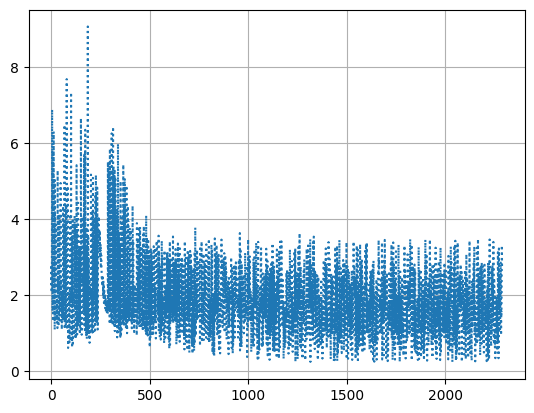

In [43]:
import matplotlib.pyplot as plt

losses = []

with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        losses.append(float(row[3]))

plt.plot(losses, label="Loss over training step", linestyle='dotted')
plt.grid()

## Model training

Now we want a phoneme recognition.
It means to train the last layer of the model to the ground truth.

In [ ]:
import csv
import os
import re

phoneme_recognizer.train()
linear_optimizer = torch.optim.Adam(
    phoneme_recognizer.phoneme_classifier.parameters(),
    lr=1e-3,
    weight_decay=0
)


def calculate_ctc_loss(log_probs, target_sequence):
    """Calculates CTC loss."""
    # Create input_lengths and target_lengths tensors
    input_lengths = torch.tensor([1])  # Batch size of 1
    target_lengths = torch.tensor([1])  # Batch size of 1

    # Calculate CTC loss
    loss = F.ctc_loss(
        log_probs,
        target_sequence,
        input_lengths=input_lengths,
        target_lengths=target_lengths
    )
    return loss

MODEL_DIR = "models"
OUTPUTS_DIR = "outputs"


def prepare_folders():
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    if not os.path.exists(OUTPUTS_DIR):
        os.makedirs(OUTPUTS_DIR)
    

def load_last_checkpoint(model_dir):
    increment = -1
    # Load the latest version
    pth_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]
    increment = len(pth_files)

    if not pth_files:
        warnings.warn("No .pth files found in the model directory! Starting from scratch!")
    else:
        # Sort the files by their index (last number)
        pth_files.sort(key=lambda x: int(re.search(r"(\d+)\.pth$", x)[1]))

        # Load the latest version
        checkpoint = pth_files[-1]  # Load the last element (highest index)
        match = re.search(r"(\d+)\.pth$", checkpoint)
        if match:
            increment = int(match[1])
            # Load the linear layer's parameters
            phoneme_recognizer.phoneme_classifier.load_state_dict(
                torch.load(f"{model_dir}/{checkpoint}")
            )
        else:
            warnings.warn("Couldn't find a model! Starting from scratch!")
    return increment

prepare_folders()
increment = load_last_checkpoint(MODEL_DIR)

# Freeze the wavlm model
for param in phoneme_recognizer.wavlm.parameters():
    param.requires_grad = False


def write_to_csv(row):
    with open(f'{OUTPUTS_DIR}/phonemes_training.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow(row)


# Training loop
for epoch in range(10):
    for i, data in enumerate(dataset.shuffle().select(range(50))):
        inputs = get_audio_features(data)
        log_probs = phoneme_recognizer(inputs)
        split_phonemes = smart_split_coder(data["phoneme_sequence"][0])
        target = phoneme_recognizer.tokenize(split_phonemes)
        loss = calculate_ctc_loss(log_probs[0], target.reshape([1, -1]))
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        write_to_csv(
            [
                increment, epoch, i, loss.item(),
                "".join(phoneme_recognizer.classify_to_phonemes(log_probs)[0]),
                "".join(split_phonemes)
            ]
        )
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        increment += 1
        torch.save(
            phoneme_recognizer.phoneme_classifier.state_dict(),
            f"{MODEL_DIR}/phoneme_classifier_epoch_{epoch}_step_{i}_{increment}.pth"
        )
    

Epoch 0, Loss: 2.4194483757019043


/home/hugo/Documents/dev/asr/Lemanic-Life-Sciences-Hackathon-2025/.venv/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 0, Loss: 3.888230800628662
Epoch 0, Loss: 1.146170735359192
Epoch 0, Loss: 6.249912738800049
Epoch 0, Loss: 1.2091354131698608
Epoch 0, Loss: 3.8059654235839844
Epoch 0, Loss: 2.063833713531494


## Binary classification

We have a model roughly trained for phonemes.
We want a binary classification though.
We won't do that for now as it would be an end-to-end pipeline, defeating the purpose of the created pipeline.